### EDA
Notebook que contiene el analisis exploratorio de los datos y tambien las propuestas para obtener insights valiosos

In [885]:
# Análisis y manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos de regresión
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Clustering
from sklearn.cluster import KMeans

# Series de tiempo
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Modelos avanzados
from xgboost import XGBRegressor


In [886]:
df= pd.read_csv(r'C:\Users\Armado\Documents\GitProjects\EDA_Proyecto\data\raw\timeforcasting.csv')
df

,User ID,Order Id,Product Id,Price,Time
0,6365,10147,7575.0,175.0,2019-03-22T00:20:26+00:00
1,1,10148,7575.0,175.0,2019-03-22T00:20:26+00:00
2,0,10146,5633.0,4.5,2019-03-20T12:42:18+00:00
3,6290,10144,7574.0,175.0,2019-03-19T19:47:17+00:00
4,1,10145,5593.0,3.5,2019-03-19T19:47:17+00:00
...,...,...,...,...,...
1508,0,6067,NaN,20.0,2014-02-13T23:43:19+00:00
1509,0,6066,NaN,20.0,2014-02-13T21:04:30+00:00
1510,0,6065,NaN,20.0,2014-02-13T20:27:19+00:00
1511,5196,6064,NaN,20.0,2014-02-13T00:35:55+00:00


#Notas relativas al dataset:
Un User ID aparece multiples veces con diferentes Product ID con diferentes valores de Time,  esto sugiere que un usuario crea una orden de pedido, dento de la orden se recogen los diferentes productos. La Fecha y hora de la operación parece estar asignada poer orden.

In [887]:
''' Descriptivos'''
#a contiinuación se generan los descriptivos de las variables del dataset
df.describe(include='all')

,User ID,Order Id,Product Id,Price,Time
count,1513.000000,1513.000000,1460.000000,1513.000000,1513
unique,NaN,NaN,NaN,NaN,1499
top,NaN,NaN,NaN,NaN,2019-03-05T18:23:02+00:00
freq,NaN,NaN,NaN,NaN,2
mean,3108.943159,6844.588896,118.500000,112.688420,NaN
std,2520.000520,542.457749,888.892554,175.592896,NaN
min,0.000000,6064.000000,0.000000,0.000000,NaN
25%,0.000000,6441.000000,0.000000,12.000000,NaN
50%,3941.000000,6819.000000,0.000000,25.000000,NaN
75%,5311.000000,7197.000000,0.000000,144.000000,NaN


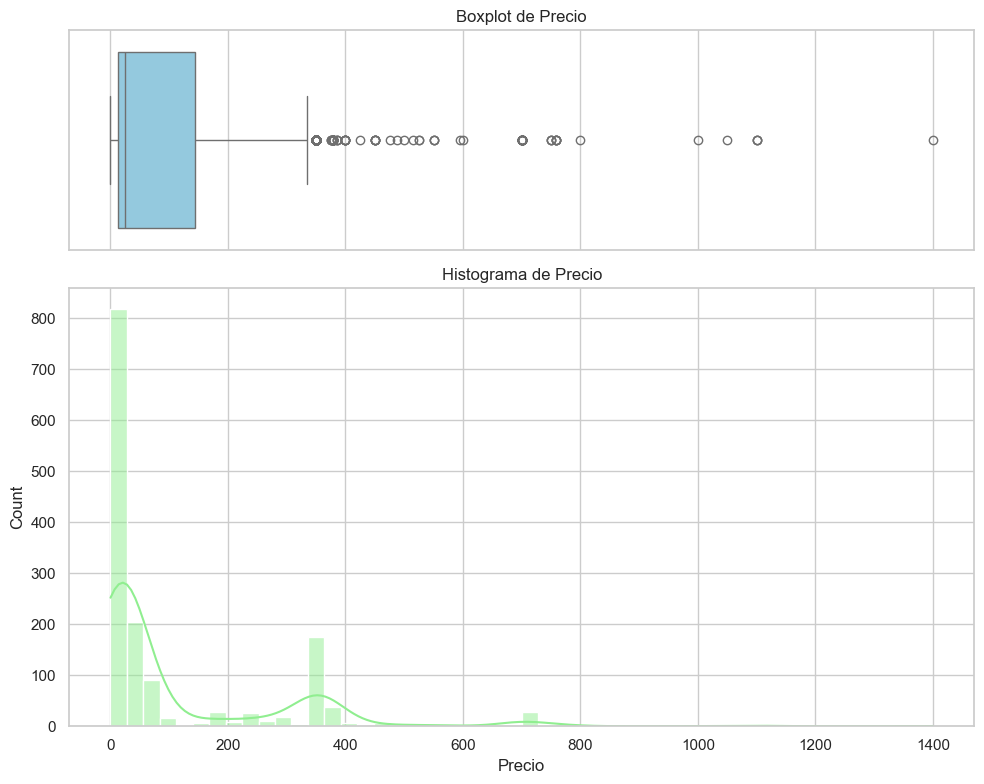

In [888]:

# Estilo visual
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [1, 2]})
# Boxplot
sns.boxplot(x=df['Price'], ax=axes[0], color='skyblue')
axes[0].set(title='Boxplot de Precio')
# Histograma
sns.histplot(x=df['Price'], ax=axes[1], bins=50, kde=True, color='lightgreen')
axes[1].set(title='Histograma de Precio', xlabel='Precio')
plt.tight_layout()
plt.show()

#Comentarios del descriptivo
 - Se puede observar que hay ciertos elementos de la columna User ID==0, esto se puede deber a datos faltantes, posiblemente por errores de sistema o de registro,  a veces tambien se usa un usuario neutro para hacer test de ordenes u opciones similares,  algo parecido pasa con el  user ID ==1.

 - Solo se tienen 1460 registrso validos para Product Id,  por lo que hay 53 valores faltantes.

 - La disperción de los datos es alta para la variable Price, hay demasiados productos con precio 0, la mayoría son menores de 400 pesos, pero el máximo es de 1400
- Adcionalmente hay 52 ordenes de producto distintas pero sin un producto asociado, aunque si tienen precio, la mayoría de estas ordenes pertenecen a Usuarios tipo 0.






In [889]:
df['Time'] = pd.to_datetime(df['Time'])
df['Time'] = df['Time'].dt.tz_localize(None)
df['year'] = df['Time'].dt.year
df['month'] = df['Time'].dt.month
df.head(5)

,User ID,Order Id,Product Id,Price,Time,year,month
0,6365,10147,7575.0,175.0,2019-03-22 00:20:26,2019,3
1,1,10148,7575.0,175.0,2019-03-22 00:20:26,2019,3
2,0,10146,5633.0,4.5,2019-03-20 12:42:18,2019,3
3,6290,10144,7574.0,175.0,2019-03-19 19:47:17,2019,3
4,1,10145,5593.0,3.5,2019-03-19 19:47:17,2019,3


In [890]:
df[df['User ID'].isin([0, 1])]

,User ID,Order Id,Product Id,Price,Time,year,month
1,1,10148,7575.0,175.0,2019-03-22 00:20:26,2019,3
2,0,10146,5633.0,4.5,2019-03-20 12:42:18,2019,3
4,1,10145,5593.0,3.5,2019-03-19 19:47:17,2019,3
6,1,10143,7574.0,175.0,2019-03-19 19:39:57,2019,3
8,1,10141,7575.0,175.0,2019-03-06 23:20:42,2019,3
...,...,...,...,...,...,...,...
1506,0,6069,NaN,20.0,2014-02-14 17:51:38,2014,2
1507,0,6068,NaN,20.0,2014-02-14 15:42:10,2014,2
1508,0,6067,NaN,20.0,2014-02-13 23:43:19,2014,2
1509,0,6066,NaN,20.0,2014-02-13 21:04:30,2014,2


# Mantenemos usuarios 0 o 1?
Se percibe que la cantidad de registros que pertenecen a usuarios 0 o 1 son aprox la tercera parte del total (37%) por lo que es importante estar seguros de que al quitarlos no se perderá una parte importante de los datos.

    - Veamos si tiene un Producto ID valido, buscando la proporción de esos registros que  tiene un Product Id.
    - Tabien se busca saber si existe un precio para esos registros.
    - Revisamos si tienen fechas validas
    - Verificamos las ordenes distintas para esos registros



# Criterio para saber si eliminar los registros User ID in (0, 1)

Sí la proporción de tales registros que tiene un Product Id valido es pequeña, significa que en general los usuarios 0 y 1 no son relevantes ya que no continen ordenes con productos validos: se usa notna para comparar. se usa tambien "!=0"

Si tiene precios inconsistentes, se pueden eliminar

Si no cuentan con un registro valido de fecha, se pueden eliminar

Si los Product_ID==0 pueden ser productos no válidos, si la proporcion es baja se podrían eliminar


In [891]:
# tabla pivote: frecuencia de Product ID
pivot_product = pd.pivot_table(df, 
                             index='Product Id',
                             aggfunc='size',
                             fill_value=0)
pivot_product.sort_values(ascending=False).head(10)

Product Id
0.0       1434
5756.0      11
7574.0       7
7575.0       6
5593.0       1
5633.0       1
dtype: int64

In [892]:
# tabla pivote: frecuencia de Product ID
pivot_product = pd.pivot_table(df, 
                             index='Price',
                             aggfunc='size',
                             fill_value=0)
pivot_product.sort_values(ascending=False).head(10)

Price
350.00    174
0.00       62
20.00      54
21.00      44
9.00       43
10.50      34
35.00      31
378.88     31
14.00      31
3.50       31
dtype: int64

In [ ]:
#Obtenemos las proporciones de ceros y nulos:
print("proporcion de nulos:")
print(1-df[df['User ID'].isin([0, 1])]['Product Id'].notna().mean())
mask = df['User ID'].isin([0, 1])
print("proporcion de ceros ó nulos:")
prop_basura = ((df.loc[mask, 'Product Id'].isna()) | (df.loc[mask, 'Product Id'] == 0)).mean()
print(prop_basura)

proporcion de nulos:
0.07964601769911506
proporcion de ceros ó nulos:
0.9699115044247788


# Limpieza del dataset

La proporcion de registros invalidaos por ser nulls en Porduct ID es del 7%, pero la proporcion de datos nulls con datos ==0 para elñ mismo campo es mas del 90%

En conclusión no se pueden eliminar tan facil los registros de los usuarios 1, 0.

Sin embargo, queda claro que las ventas =0 no reflejan informacion de ventas reales.

Priorizando la entrega del proyecto bajo las mejores condiciones asequibles, se opta por continuar con la limpieza sin eliminar tantos registros. No obstante es necesario realizar 3 preguntas a los data owners o reunirse con el área comercial: 1.- ¿Que representan los usuarios 0, 1? 2.- ¿A qué se refieren los precios = 0? ¿A qué se debe la ausencia de registros de Product ID y Product ID ==0?

Se decide que la limpieza de los datos solo implicará df['Price'] > 0 y se imputarán los datos nulls de Product ID con ceros

In [ ]:
#filtrtramos price ==0
df = df[df['Price'] > 0].copy()
df['Product Id'] = df['Product Id'].fillna(0)
df['Product Id'] = df['Product Id'].astype(int)
df

,User ID,Order Id,Product Id,Price,Time,year,month
0,6365,10147,7575,175.0,2019-03-22 00:20:26,2019,3
1,1,10148,7575,175.0,2019-03-22 00:20:26,2019,3
2,0,10146,5633,4.5,2019-03-20 12:42:18,2019,3
3,6290,10144,7574,175.0,2019-03-19 19:47:17,2019,3
4,1,10145,5593,3.5,2019-03-19 19:47:17,2019,3
...,...,...,...,...,...,...,...
1508,0,6067,0,20.0,2014-02-13 23:43:19,2014,2
1509,0,6066,0,20.0,2014-02-13 21:04:30,2014,2
1510,0,6065,0,20.0,2014-02-13 20:27:19,2014,2
1511,5196,6064,0,20.0,2014-02-13 00:35:55,2014,2


In [ ]:
# Ordenamos los precios de menor a mayor
df_sorted = df.sort_values('Price', ascending=True)
print("Distribución de precios ordenados:")
print("\nPrimeros 10 precios más bajos:")
print(df_sorted['Price'].head(10))
print("\nÚltimos 10 precios más altos:")
print(df_sorted['Price'].tail(10))

Distribución de precios ordenados:

Primeros 10 precios más bajos:
800     2.5
4       3.5
648     3.5
1387    3.5
1350    3.5
701     3.5
720     3.5
61      3.5
1329    3.5
1295    3.5
Name: Price, dtype: float64

Últimos 10 precios más altos:
1322     757.75
1213     757.75
1283     757.75
1066     800.00
116     1000.00
119     1050.00
810     1100.00
849     1100.00
1049    1100.00
939     1400.00
Name: Price, dtype: float64


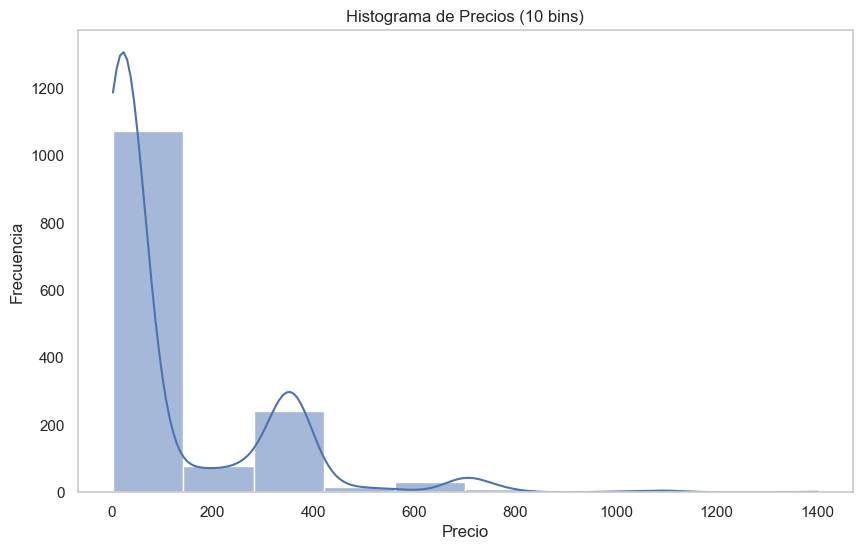

In [ ]:
# revisamos la distribución de precios
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Price', bins=10, kde=True)
plt.title('Histograma de Precios (10 bins)')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.grid(False)
plt.show()

Outliers y valores extremos:
A decir del histograma inicial y del actual, se puede apreciar una muy pequeña venta de productos de alto precio. En orden de obtener los mejores insights (en cantidad y calidad), es importante entender la estructura de los datos que son mayoría. Por lo cual hacemos una prueba para ello, mediante la eliminación de los valores extremos.

Comenzamos Con el métono mas elemental (Rango intercuartílico).


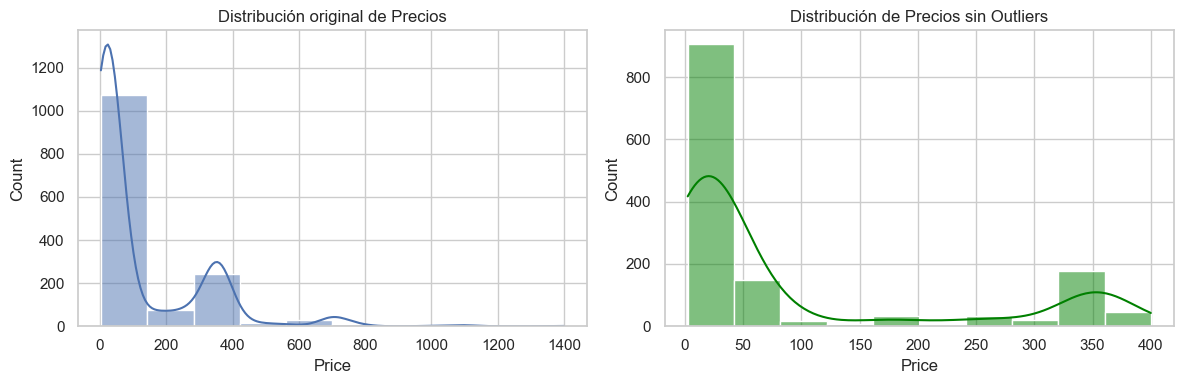

In [ ]:
# Calculamos los cuartiles y definimos los limites sup e inf
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
RI = Q3 - Q1
limite_inferior = Q1 - 1.5 * RI
limite_superior = Q3 + 1.5 * RI

# eliminamos los valores extremos
df_filtrado = df[(df['Price'] >= limite_inferior) & (df['Price'] <= limite_superior)]

# Histograma antes
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(df['Price'], bins=10, kde=True)
plt.title('Distribución original de Precios')
# Histograma después
plt.subplot(1, 2, 2)
sns.histplot(df_filtrado['Price'], bins=10, kde=True, color='green')
plt.title('Distribución de Precios sin Outliers')
plt.tight_layout()
plt.show()

#Distribución Multiimodal
La distribución multimodal parece ser una característica del dataset, aun habiendo limpiado los valores extremos, se visualiza 

Incluso después de la eliminación de outliers, la distribución sigue sin ser normal y conserva una clara bimodalidad Hay dos "picos" prominentes: uno muy alto cerca de los precios bajos y otro más pequeño despues de 300 pesos.

En mi experiencia, esta estructura representa productos de bajo precio altamente demandados, como productos de primera necesidad o perecederos, y los productos de precio relativamente altos pueden deberse a dos tipos de productos: ya bien prodctos gourmet o premium, o bien productos que no son de primera necesidad pero muy demandados tambien, por ejemplo ropa o cosmeticos.

Los productos que Superaban los 1000 pesos podrían corresponder al área de electrónica o de vinos y licores.


# Serie temporal
A continuación se grafica la serie temporal de los datos y de los datos filtrados

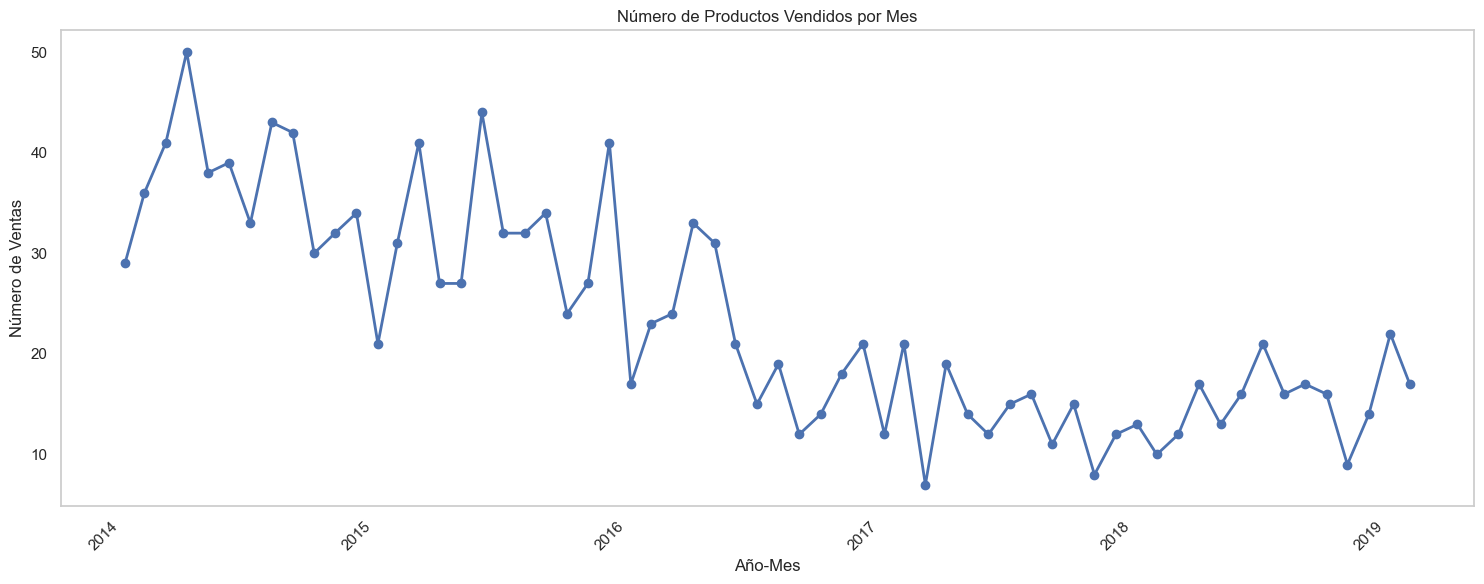


Estadísticas de ventas mensuales:

Mes con más ventas:
     Aniomes  Product Id
6 2014-05-01          50

Mes con menos ventas:
      Aniomes  Product Id
41 2017-04-01           7

Promedio mensual de ventas: 23.4


In [ ]:

df['Aniomes']=df['year'].astype(str) + '-' + df['month'].astype(str)

# Agrupación y recuentode ventas por mes
ventas_mensuales = df.groupby('Aniomes')['Product Id'].count().reset_index()
ventas_mensuales = ventas_mensuales.sort_values('Aniomes')  # Ordenar por fecha
# 'Aniomes' DEBE ser tipo datetime
ventas_mensuales['Aniomes'] = pd.to_datetime(ventas_mensuales['Aniomes'])

#grafica
ventas_mensuales = ventas_mensuales.sort_values('Aniomes')

plt.figure(figsize=(15, 6))
plt.plot(ventas_mensuales['Aniomes'], ventas_mensuales['Product Id'], 'b-o', linewidth=2)
plt.title('Número de Productos Vendidos por Mes')
plt.xlabel('Año-Mes')
plt.ylabel('Número de Ventas')
plt.grid(False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#  estadísticas mensuales
print("\nEstadísticas de ventas mensuales:")
print("\nMes con más ventas:")
print(ventas_mensuales.sort_values('Product Id', ascending=False).head(1))
print("\nMes con menos ventas:")
print(ventas_mensuales.sort_values('Product Id', ascending=True).head(1))
print("\nPromedio mensual de ventas:", ventas_mensuales['Product Id'].mean().round(2))

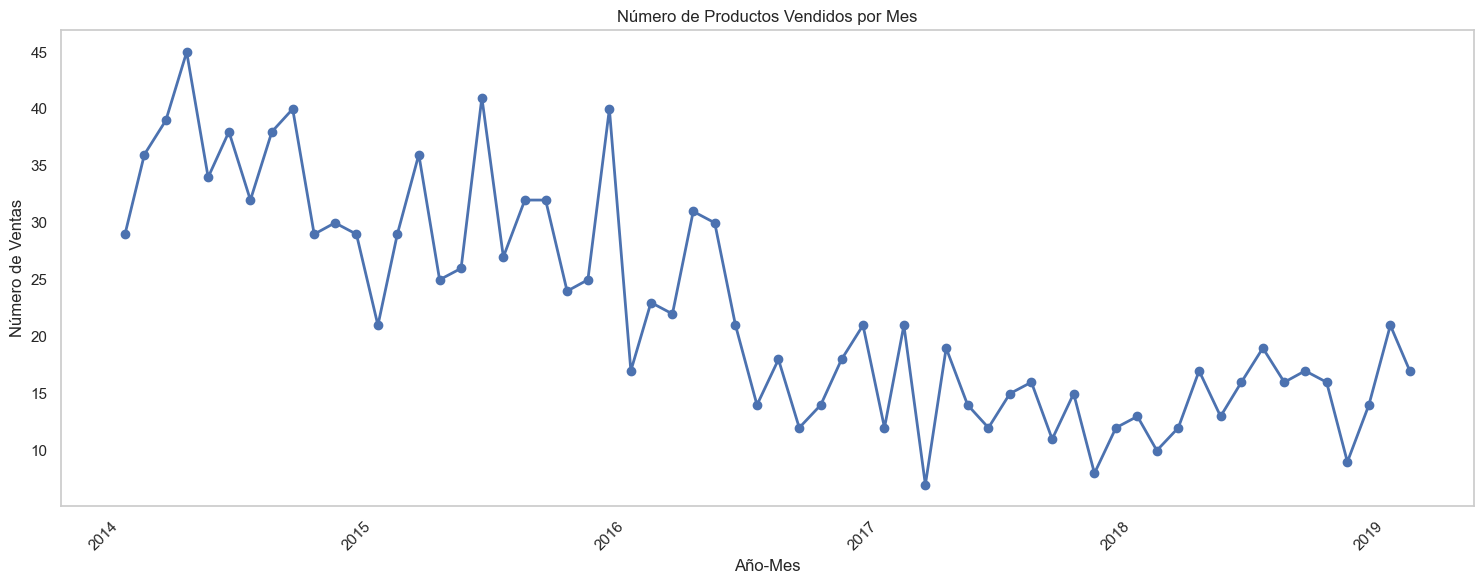


Estadísticas de ventas mensuales:

Mes con más ventas:
     Aniomes  Product Id
6 2014-05-01          45

Mes con menos ventas:
      Aniomes  Product Id
41 2017-04-01           7

Promedio mensual de ventas: 22.42


In [ ]:
#Comparamos para saber si podemos trabajar con el dataset filtrado
df_filtrado['Aniomes']=df_filtrado['year'].astype(str) + '-' + df_filtrado['month'].astype(str)

ventas_mensuales = df_filtrado.groupby('Aniomes')['Product Id'].count().reset_index()
ventas_mensuales = ventas_mensuales.sort_values('Aniomes') 
ventas_mensuales['Aniomes'] = pd.to_datetime(ventas_mensuales['Aniomes'])

ventas_mensuales = ventas_mensuales.sort_values('Aniomes')
#Grafica
plt.figure(figsize=(15, 6))
plt.plot(ventas_mensuales['Aniomes'], ventas_mensuales['Product Id'], 'b-o', linewidth=2)
plt.title('Número de Productos Vendidos por Mes')
plt.xlabel('Año-Mes')
plt.ylabel('Número de Ventas')
plt.grid(False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nEstadísticas de ventas mensuales:")
print("\nMes con más ventas:")
print(ventas_mensuales.sort_values('Product Id', ascending=False).head(1))
print("\nMes con menos ventas:")
print(ventas_mensuales.sort_values('Product Id', ascending=True).head(1))
print("\nPromedio mensual de ventas:", ventas_mensuales['Product Id'].mean().round(2))

Como no hay una diferencia cualitativa en el desarrollo histórico de la serie se decide contnuar con el analisis de la serie filtrada siin valores extremos.

La serie muestra una tendencia decreciente general, presenta una volatilidad que podría ser desctrita como media, A simple vista se puede ver estacionalidad simple: una caida de las ventas cada unicio de año, esto puede ser por la caida en el ingreso disponible de las familias despues de las fiestas decembrinas. Hay picos a mitad de año que se vuelven menos pronunciados a medida que pasan los años.

las fluctuaciones entre cada estacionalidad mencionada no muestran un patron aparente.

Las ventas parecieran comenzar un leve periodo de recuperacion al final de la serie.


In [900]:
df_filtrado.to_csv(r'C:\Users\Armado\Documents\GitProjects\EDA_Proyecto\data\processed\dataset filtrado.csv', index=False)

# Propuestas
A partir del analisis exploratorio de datos anterior previo

A partir de aqui se propoonen 4 caminos a seguir:
    1.- Analissi de las ventas usando series de tiempo
    2.- Análisis de la estructura de las ventas usando modelos no supervisados se sugiere Clustering para agrupar clientes por patron de compra.
    3.- Desarrollo mixto,  se encuentran los diferentes tipos de clientes segun sus patrones de consumo y a cada cluster es analizado a travppés de un análisis de regresion para mejor calidad en el pronóstico de las ventas.

    4.- Análisis de la demanda (este es el punto nuclear de una propuesta robusta, sin embargo, son necesarias más características para generar insigths que valgan la pena)

    Avancemos con la propuesta 3 que parece ser la más robusta y que tiene el potencial de añadir mas valor y conocimiento sobre las ventas en general, pero tambien tiene el potencial de ser mas preciso en una predicción:



# Clustering

Primnero tratamos de encontrar patrones no visibles dentro del dataset segun el tipo de conducta de ada usuario.

Hacemos un poco de "Feature engineering" muyt basica con el fin de definir los predictores del "patron de compra"
   

In [ ]:
df_filtrado['Time'] = pd.to_datetime(df_filtrado['Time'])

# Agrupación por usuario
df_user = df_filtrado.groupby('User ID').agg(
    total_orders=('Order Id', 'nunique'),
    unique_products=('Product Id', 'nunique'),
    avg_price=('Price', 'mean'),
    total_gasto=('Price', 'sum'),
    primera_compra=('Time', 'min'),
    ult_compra=('Time', 'max'),
    mes_act=('Aniomes', 'nunique')
).reset_index()

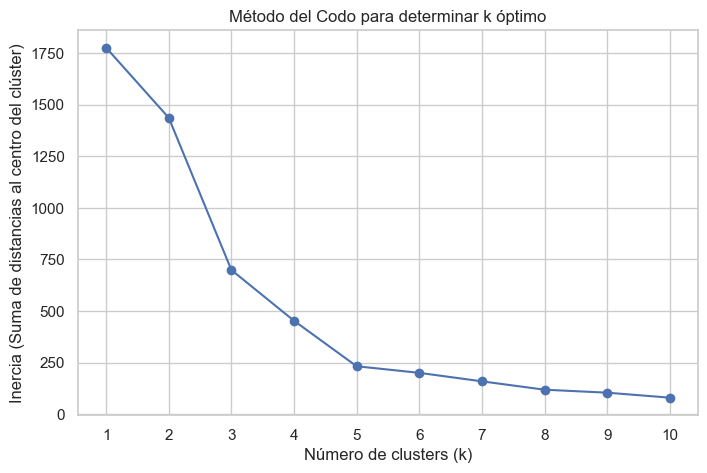

In [ ]:
#metodo del Elbow
df_user['dias_entre_compras'] = (df_user['ult_compra'] - df_user['primera_compra']).dt.days

features = ['total_orders', 'unique_products', 'avg_price',
            'total_gasto', 'mes_act', 'dias_entre_compras']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_user[features])


inertias = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertias, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia (Suma de distancias al centro del clúster)')
plt.title('Método del Codo para determinar k óptimo')
plt.grid(True)
plt.xticks(K)
plt.show()


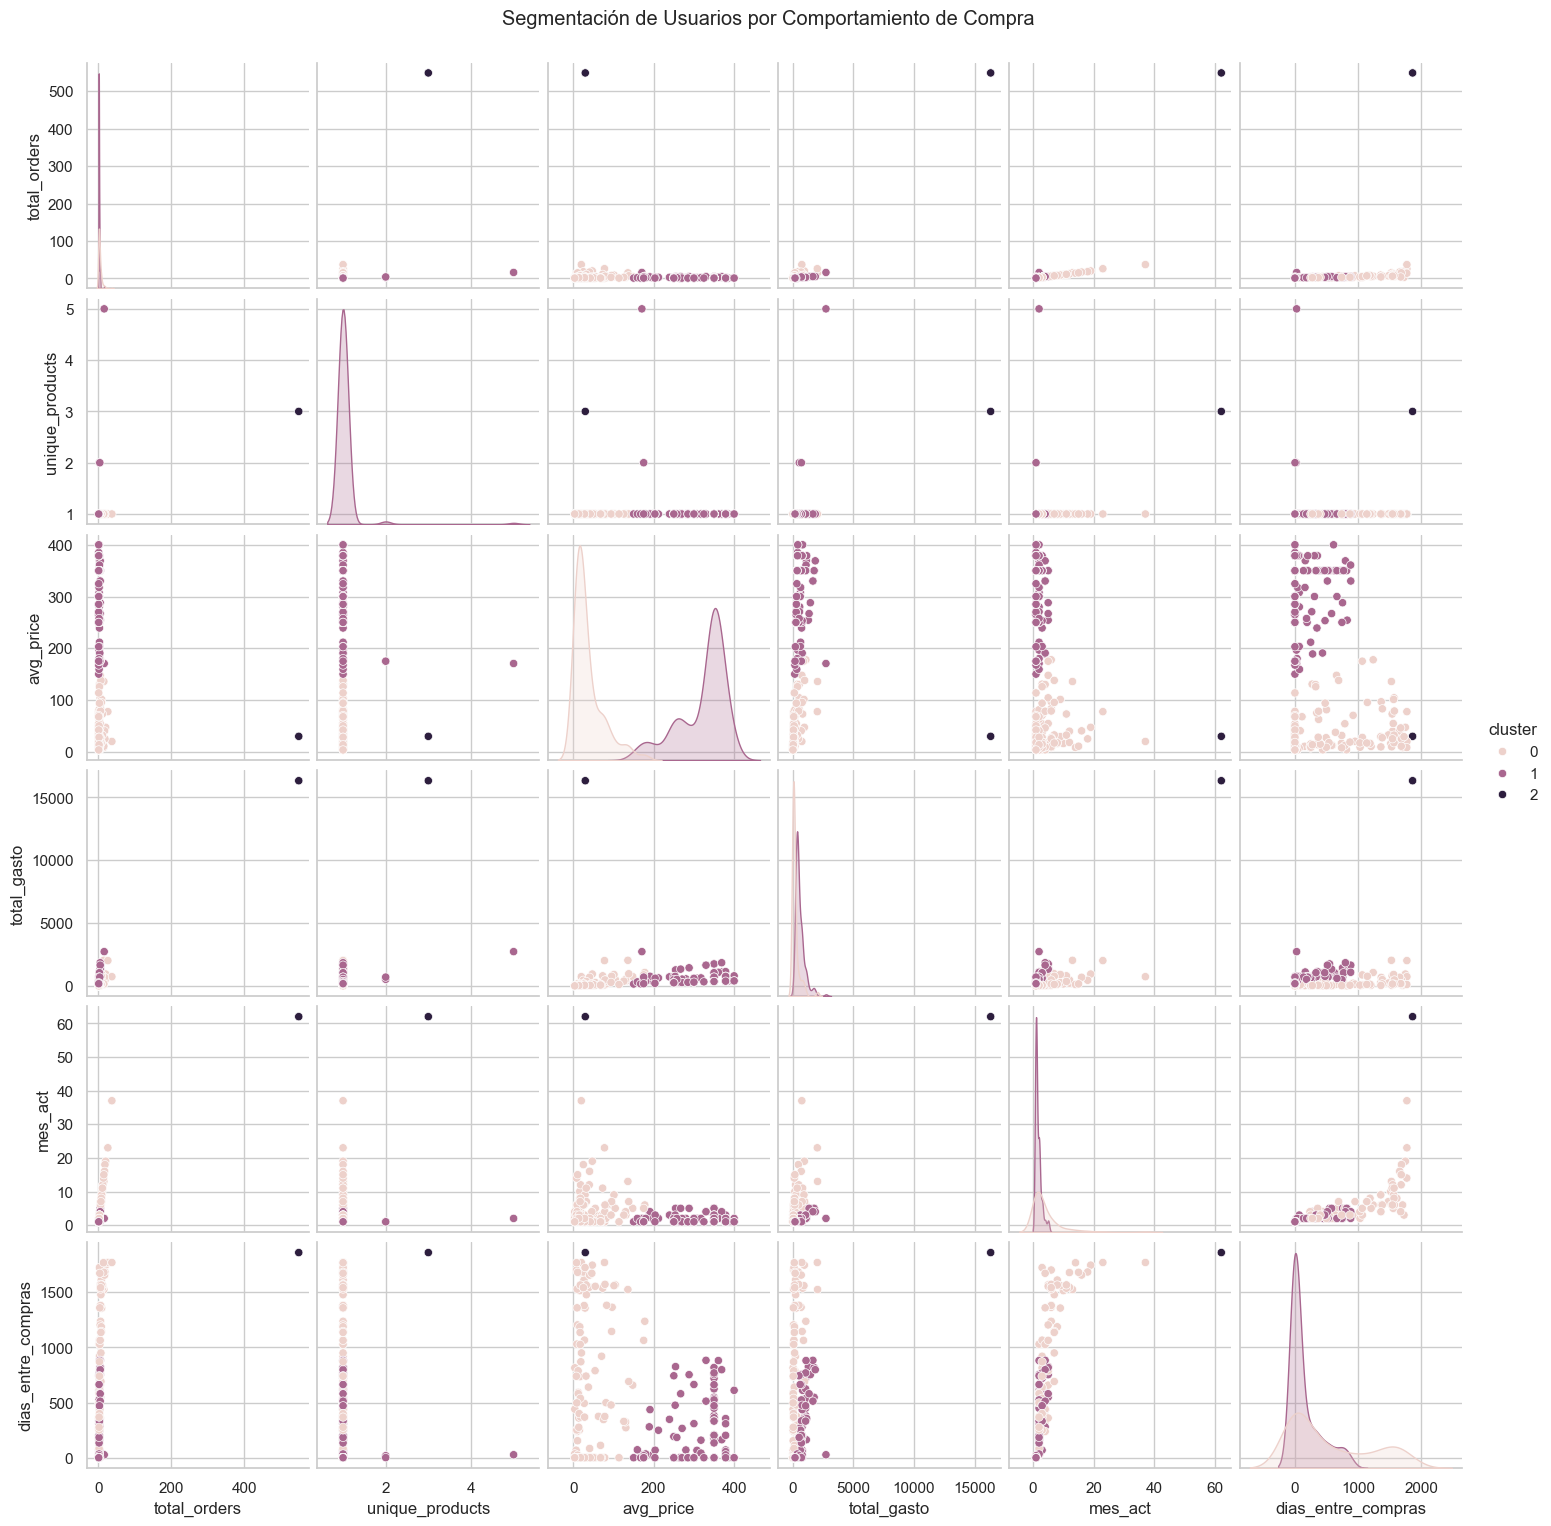

         total_orders  unique_products   avg_price   total_gasto    mes_act  \
cluster                                                                       
0            4.000000         1.000000   36.274388    177.203741   3.920863   
1            1.820513         1.038462  320.694773    559.914808   1.641026   
2          549.000000         3.000000   29.752459  16334.100000  62.000000   

         dias_entre_compras  
cluster                      
0                547.992806  
1                147.717949  
2               1860.000000  


In [ ]:
# Con base en el resultado del elbow tomamos 3 clústers
kmeans = KMeans(n_clusters=3, random_state=42)
# OJo, el problema es que el Cluster 3 podría agrupar muy poquitos
df_user['cluster'] = kmeans.fit_predict(X_scaled)

sns.pairplot(df_user, hue='cluster', vars=features)
plt.suptitle("Segmentación de Usuarios por Comportamiento de Compra", y=1.02)
plt.show()

print(df_user.groupby('cluster')[features].mean())


La gráfica de dispersión por pares muestra una segmentación clara de usuarios basada en su comportamiento de compra. En la diagonal se observan distribuciones sesgadas, especialmente en variables como avg_price y total_gasto, indicando la presencia de usuarios con gastos altos pero poco frecuentes. Fuera de la diagonal, se aprecian relaciones entre variables que refuerzan la separación entre clústeres: por ejemplo, algunos usuarios compran con frecuencia y gastan más (Cluster 0), otros muestran un comportamiento intermedio (Cluster 1) y un grupo pequeño representa casos atípicos o de baja actividad (Cluster 2). Esto confirma que el clustering capta distintos patrones de consumo útiles para una estrategia segmentada.

#Se probarán los siguientes modelos: 

    - Media Móvil
    - Regresión polinomial
    - SARIMA
    - Holt-Winters
    - XGBoost

    meses a pronosticar: 5

    User ID Order Id Product Id       Price          
               count    nunique        mean       sum
0         0      549          3   29.752459  16334.10
1         1       16          5  170.531250   2728.50
2      3236        5          1  147.700000    738.50
3      3241        1          1  350.000000    350.00
4      3255       10          1   15.915000    159.15
..      ...      ...        ...         ...       ...
291    6322        2          1   28.000000     56.00
292    6337        2          1   13.500000     27.00
293    6340        1          1    3.500000      3.50
294    6351        1          1  113.660000    113.66
295    6365        1          1  175.000000    175.00

[296 rows x 5 columns]


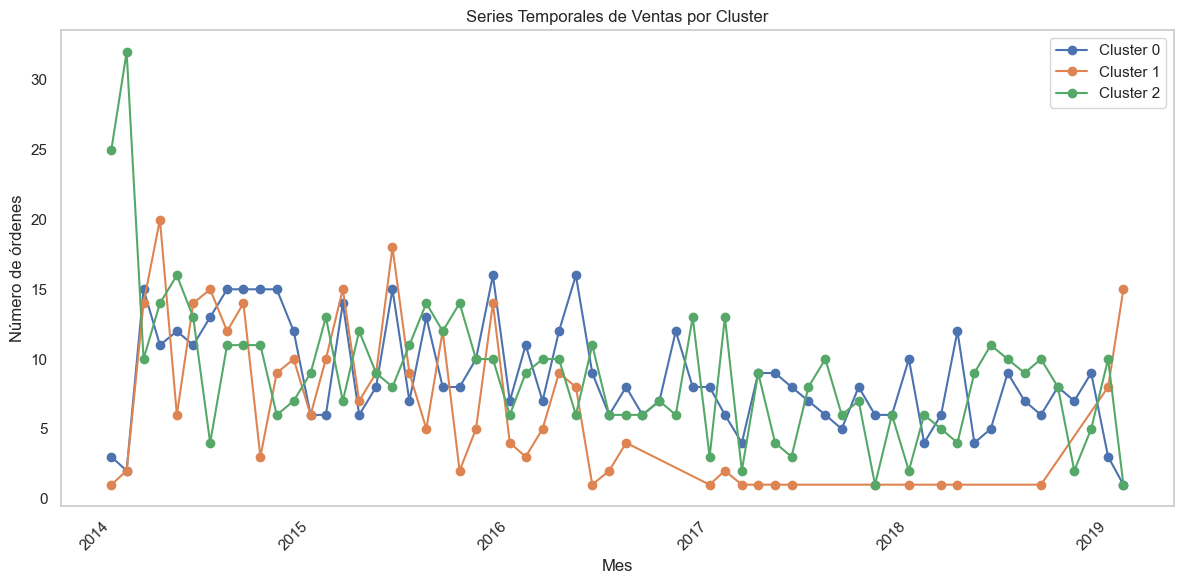

In [ ]:
# Group by usuario y obtención de las estadísticas de comportamiento
df_user = df_filtrado.groupby('User ID').agg({
    'Order Id': 'count',         
    'Product Id': 'nunique', 
    'Price': ['mean', 'sum']    
}).reset_index()

print(df_user)

# Renombramos para evitar confusión
df_user.columns = ['User ID', 'Total_Ordenes', 'Productos_Distintos', 'Precio_Promedio', 'Gasto_Total']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_user.drop('User ID', axis=1))
kmeans = KMeans(n_clusters=3, random_state=42)
df_user['Cluster'] = kmeans.fit_predict(X_scaled)
df_filtrado = df_filtrado.merge(df_user[['User ID', 'Cluster']], on='User ID', how='left')

df_filtrado['Aniomes'] = pd.to_datetime(df_filtrado['Aniomes'])
ventas_por_cluster = df_filtrado.groupby(['Aniomes', 'Cluster'])['Order Id'].count().reset_index()
ventas_por_cluster = ventas_por_cluster.sort_values('Aniomes')

# Grafica  por clusters
plt.figure(figsize=(12,6))
for c in ventas_por_cluster['Cluster'].unique():
    subset = ventas_por_cluster[ventas_por_cluster['Cluster'] == c].sort_values('Aniomes')
    plt.plot(subset['Aniomes'], subset['Order Id'], marker='o', label=f'Cluster {c}')

plt.title('Series Temporales de Ventas por Cluster')
plt.xlabel('Mes')
plt.ylabel('Número de órdenes')
plt.xticks(rotation=45)
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()


#Media Movil
Con el fin de suavizar las series de tiempo y entender de manera mas general los datos se propone generar una media movil para cada serie. esta media movil podría ser usad en un futoro como un proxi para generar pornóstcos

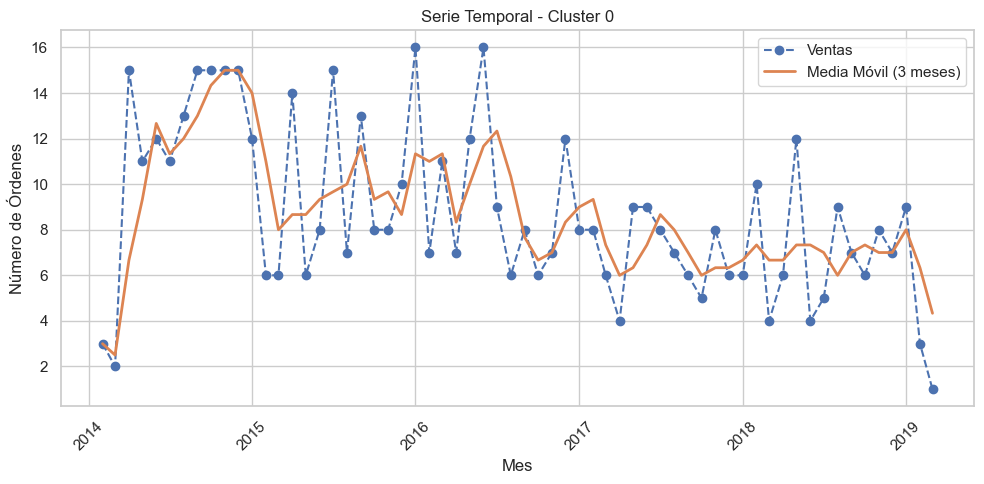

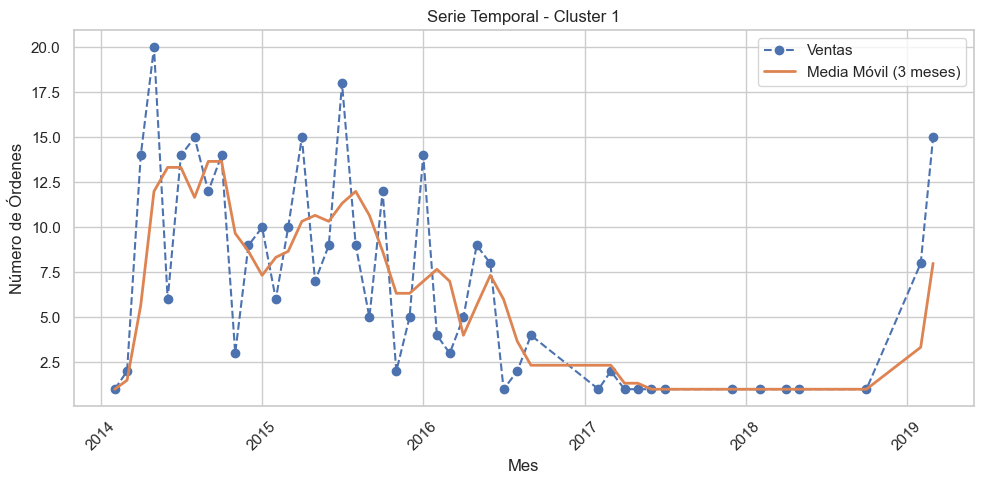

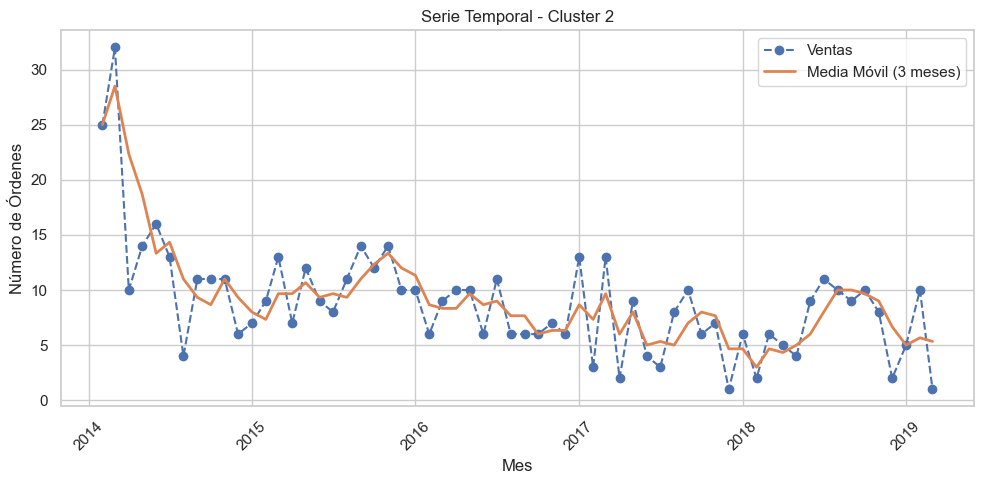

In [ ]:
# Calculo de la Mediamovil simple, la hipótesis es que se podría usar este metodo 
# para generar una predicción general, sin embargo es dudoso debido a la volatilidad 
# apartente de las ventas de cada cluster

ventas_por_cluster = ventas_por_cluster.sort_values(['Cluster', 'Aniomes'])

ventas_por_cluster['media_movil'] = ventas_por_cluster.groupby('Cluster')['Order Id'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# Grafica
clusters = ventas_por_cluster['Cluster'].unique()
for c in clusters:
    subset = ventas_por_cluster[ventas_por_cluster['Cluster'] == c]

    plt.figure(figsize=(10, 5))
    plt.plot(subset['Aniomes'], subset['Order Id'], label='Ventas', marker='o', linestyle='--')
    plt.plot(subset['Aniomes'], subset['media_movil'], label='Media Móvil (3 meses)', linewidth=2)

    plt.title(f'Serie Temporal - Cluster {c}')
    plt.xlabel('Mes')
    plt.ylabel('Número de Órdenes')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Generando predicciones para 5 meses usando Media Móvil (ventana=3)


--- Cluster 0 ---
Pronóstico: 7.33 órdenes
Valores reales: [8, 7, 9, 3, 1]
MAE: 2.67
RMSE: 3.53
MAPE: 161.88%


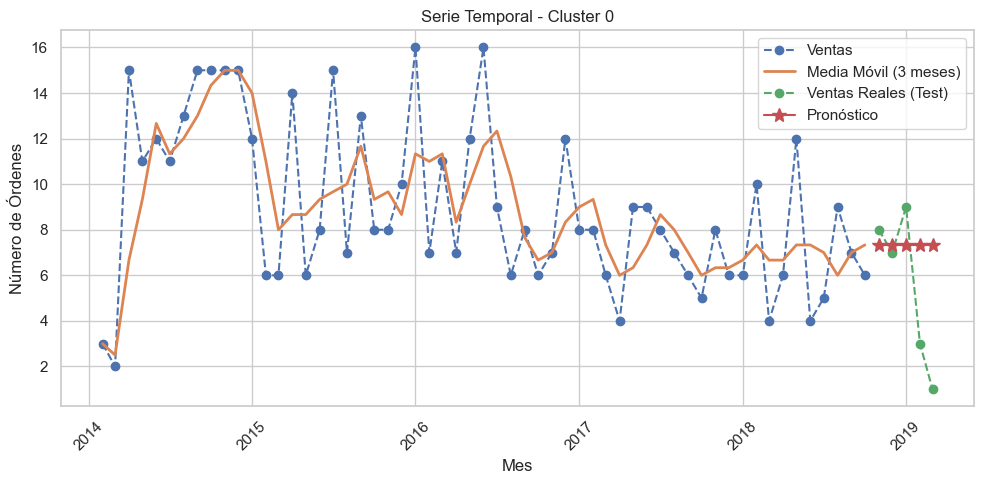


--- Cluster 1 ---
Pronóstico: 1.00 órdenes
Valores reales: [1, 1, 1, 8, 15]
MAE: 4.20
RMSE: 7.00
MAPE: 36.17%


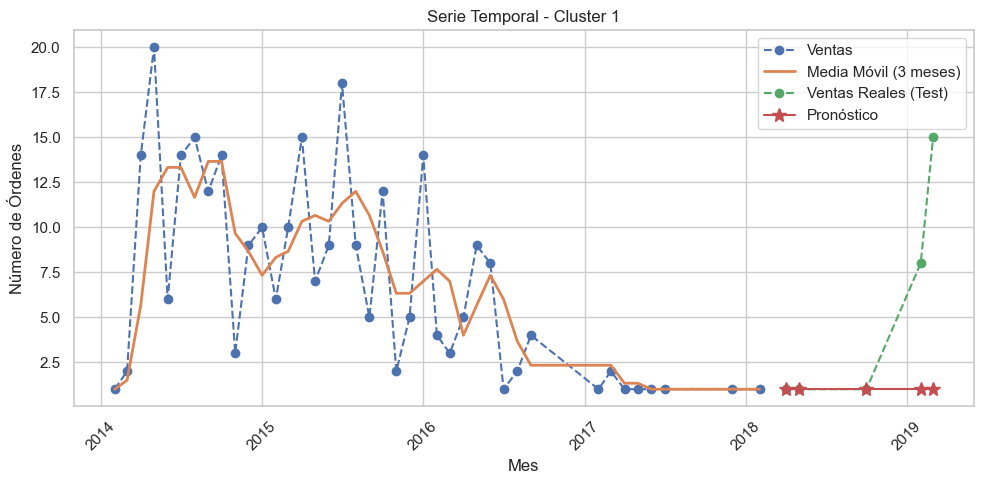


--- Cluster 2 ---
Pronóstico: 9.67 órdenes
Valores reales: [8, 2, 5, 10, 1]
MAE: 4.60
RMSE: 5.63
MAPE: 273.50%


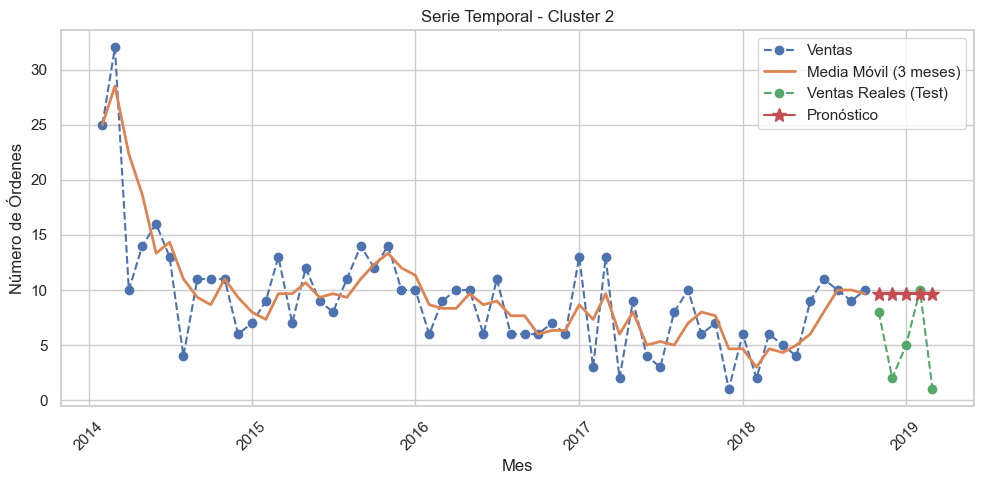


MÉTRICAS GLOBALES
MAE Global: 3.82
RMSE Global: 5.57
MAPE Global: 157.18%


In [ ]:
#Predicción usando la media movil

window_size = 3 
forecast_horizon = 5  
ventas_por_cluster = ventas_por_cluster.sort_values(['Cluster', 'Aniomes']).reset_index(drop=True)
# datos en entrenamiento y prueba
train_data = pd.DataFrame()
test_data = pd.DataFrame()

clusters_ids = ventas_por_cluster['Cluster'].unique()
for c in clusters_ids:
    subset = ventas_por_cluster[ventas_por_cluster['Cluster'] == c].copy()
    train_subset = subset.iloc[:-forecast_horizon]
    test_subset = subset.iloc[-forecast_horizon:]
    
    train_data = pd.concat([train_data, train_subset])
    test_data = pd.concat([test_data, test_subset])

# predicciones y evaluaciones
print(f"Generando predicciones para {forecast_horizon} meses usando Media Móvil (ventana={window_size})\n")

all_predictions = []
all_actuals = []
metrics_by_cluster = {}

for c in clusters_ids:
    train_subset = train_data[train_data['Cluster'] == c].copy()
    test_subset = test_data[test_data['Cluster'] == c].copy()
    

    if len(train_subset) >= window_size:
        last_known_values = train_subset['Order Id'].tail(window_size)
        forecast_value = last_known_values.mean()
        predictions = [forecast_value] * forecast_horizon
        actuals = test_subset['Order Id'].tolist()
        

        all_predictions.append(predictions)
        all_actuals.append(actuals)
        

        mae = mean_absolute_error(actuals, predictions)
        mse = mean_squared_error(actuals, predictions)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((np.array(actuals) - np.array(predictions)) / (np.array(actuals) + 1e-8))) * 100
        
        metrics_by_cluster[c] = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape
        }
        

        print(f"\n--- Cluster {c} ---")
        print(f"Pronóstico: {forecast_value:.2f} órdenes")
        print(f"Valores reales: {actuals}")
        print(f"MAE: {mae:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAPE: {mape:.2f}%")
        

        plt.figure(figsize=(10, 5))
        

        train_subset['media_movil'] = train_subset['Order Id'].rolling(window=window_size, 
                                                                      min_periods=1).mean()
        
        plt.plot(train_subset['Aniomes'], train_subset['Order Id'], 
                label='Ventas', marker='o', linestyle='--')
        plt.plot(train_subset['Aniomes'], train_subset['media_movil'], 
                label=f'Media Móvil ({window_size} meses)', linewidth=2)
        
        
        plt.plot(test_subset['Aniomes'], test_subset['Order Id'], 
                label='Ventas Reales (Test)', marker='o', linestyle='--')

        plt.plot(test_subset['Aniomes'], predictions, 
                label='Pronóstico', marker='*', linestyle='-', markersize=10)
        
        plt.title(f'Serie Temporal - Cluster {c}')
        plt.xlabel('Mes')
        plt.ylabel('Número de Órdenes')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()


flat_predictions = [item for sublist in all_predictions for item in sublist]
flat_actuals = [item for sublist in all_actuals for item in sublist]

if flat_actuals and flat_predictions:
    global_mae = mean_absolute_error(flat_actuals, flat_predictions)
    global_rmse = np.sqrt(mean_squared_error(flat_actuals, flat_predictions))
    global_mape = np.mean(np.abs((np.array(flat_actuals) - np.array(flat_predictions)) / 
                                (np.array(flat_actuals) + 1e-8))) * 100
    
    print("\n" + "="*40)
    print("MÉTRICAS GLOBALES")
    print("="*40)
    print(f"MAE Global: {global_mae:.2f}")
    print(f"RMSE Global: {global_rmse:.2f}")
    print(f"MAPE Global: {global_mape:.2f}%")
    print("="*40)

MAE: 2.99
RMSE: 3.78
R2 Score: 0.44
Pronósticos para los siguientes 3 meses: [ 8.72730885  9.62399765 10.66366734 11.85743676 13.21679735 14.75361314]


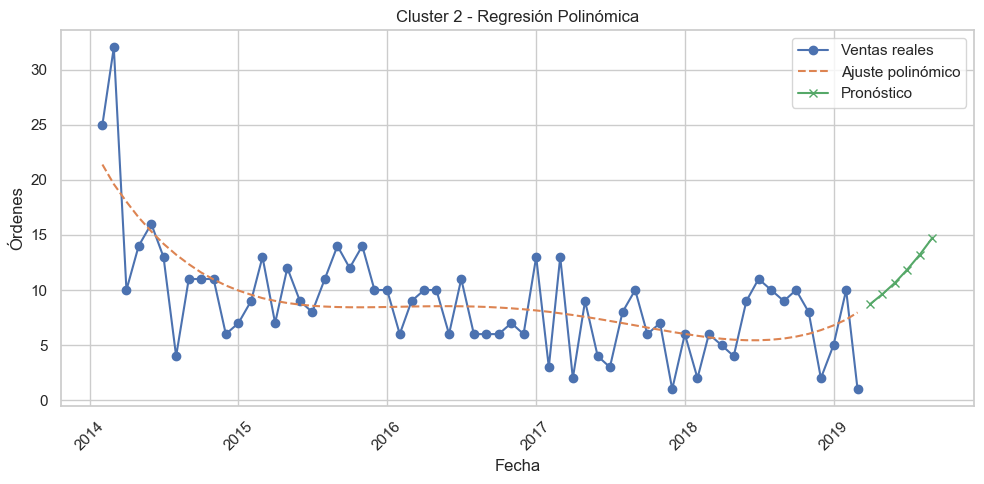

In [ ]:
#Regresión polinómica:
cluster_id =2
subset = ventas_por_cluster[ventas_por_cluster['Cluster'] == cluster_id].copy()

subset = subset.sort_values('Aniomes').reset_index(drop=True)
subset['time_index'] = np.arange(len(subset))

# Variables para regresión
X = subset[['time_index']]
y = subset['Order Id']

# características polinómicas de grado n
poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(X)

#  modelo
model = LinearRegression()
model.fit(X_poly, y)

y_pred = model.predict(X_poly)

mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")
# Predecir próximos 3 meses
future_indices = np.arange(len(X), len(X)+6).reshape(-1, 1)
future_poly = poly.transform(future_indices)
future_preds = model.predict(future_poly)
#grfica 
print("Pronósticos para los siguientes 3 meses:", future_preds)
plt.figure(figsize=(10,5))
plt.plot(subset['Aniomes'], y, label='Ventas reales', marker='o')
plt.plot(subset['Aniomes'], y_pred, label='Ajuste polinómico', linestyle='--')

future_dates = pd.date_range(subset['Aniomes'].max(), periods=7, freq='MS')[1:]
plt.plot(future_dates, future_preds, label='Pronóstico', marker='x')

plt.title(f'Cluster {cluster_id} - Regresión Polinómica')
plt.xlabel('Fecha')
plt.ylabel('Órdenes')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


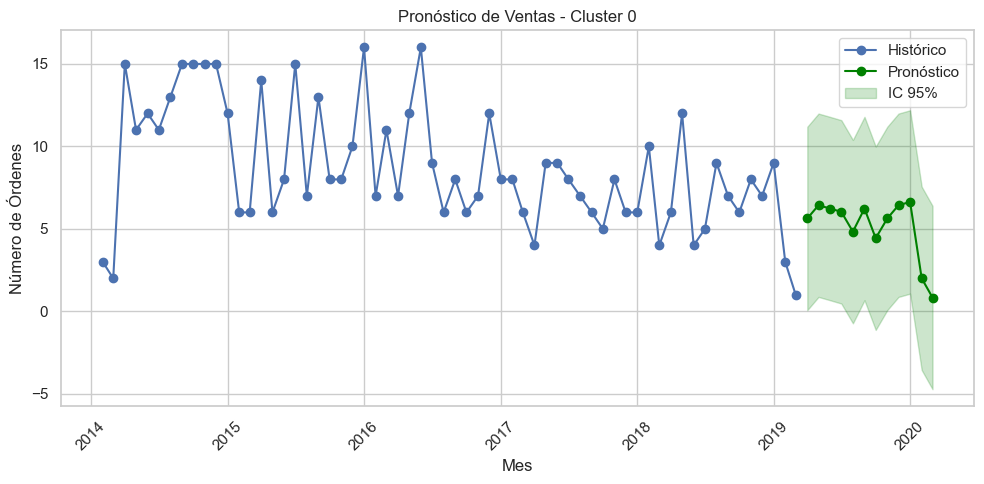

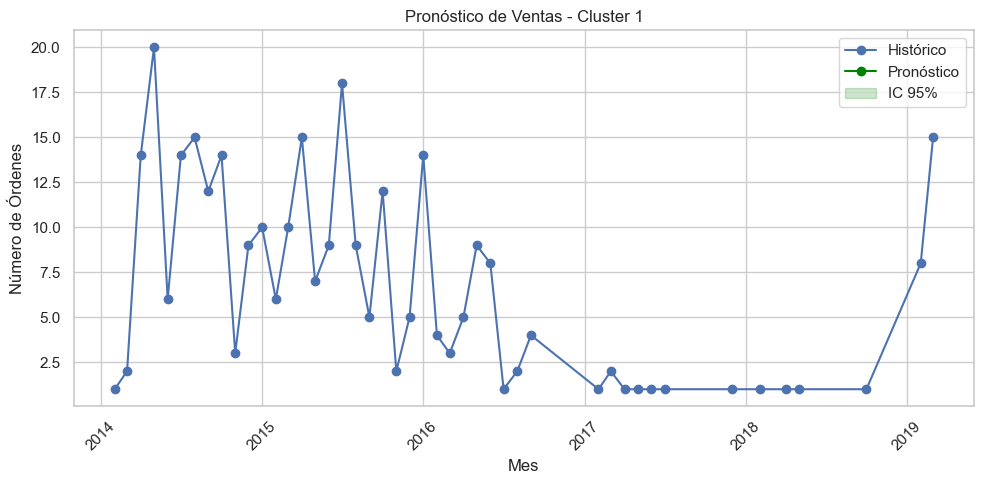

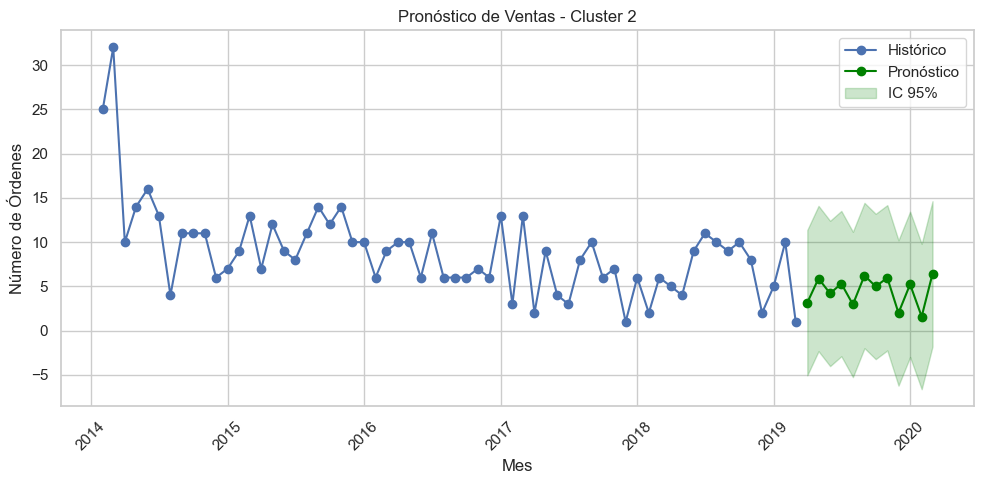

In [ ]:
#HoltWinters

ventas_por_cluster['Aniomes'] = pd.to_datetime(ventas_por_cluster['Aniomes'])

# Pronóstico para cada cluster
for c in ventas_por_cluster['Cluster'].unique():
    subset = ventas_por_cluster[ventas_por_cluster['Cluster'] == c].copy()
    subset = subset.sort_values('Aniomes')

    ts = subset.set_index('Aniomes')['Order Id']

    model = ExponentialSmoothing(ts, trend='add', seasonal='add', seasonal_periods=12)
    fit = model.fit()

    pred = fit.forecast(12)

    last_date = ts.index[-1]
    future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=12, freq='MS')

    # Obtener intervalos de confianza
    resid = fit.resid
    stderr = resid.std()
    conf_int = 1.96 * stderr

    forecast_df = pd.DataFrame({
        'forecast': pred,
        'lower': pred - conf_int,
        'upper': pred + conf_int
    }, index=future_dates)

    # Grafica
    plt.figure(figsize=(10, 5))
    plt.plot(ts.index, ts.values, label='Histórico', marker='o')
    plt.plot(forecast_df.index, forecast_df['forecast'], label='Pronóstico', marker='o', color='green')
    plt.fill_between(forecast_df.index, forecast_df['lower'], forecast_df['upper'], color='green', alpha=0.2, label='IC 95%')
    plt.title(f'Pronóstico de Ventas - Cluster {c}')
    plt.xlabel('Mes')
    plt.ylabel('Número de Órdenes')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


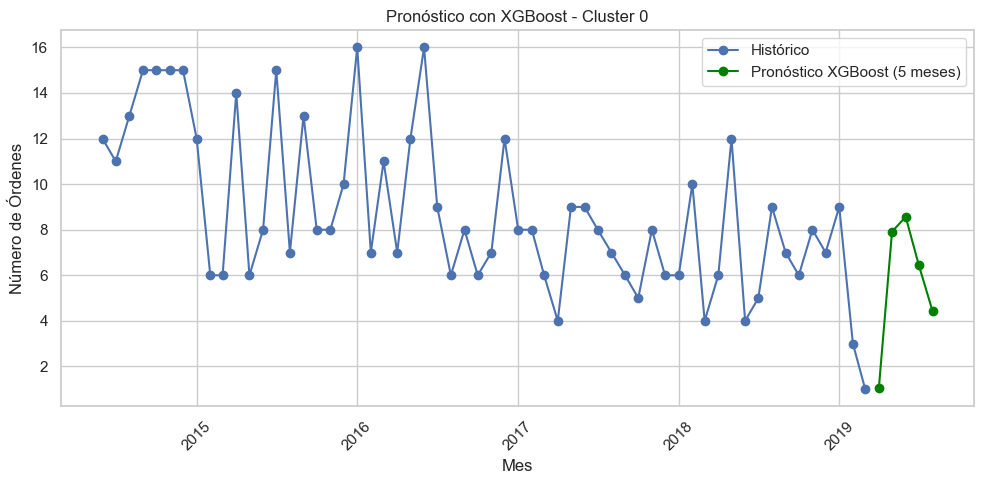

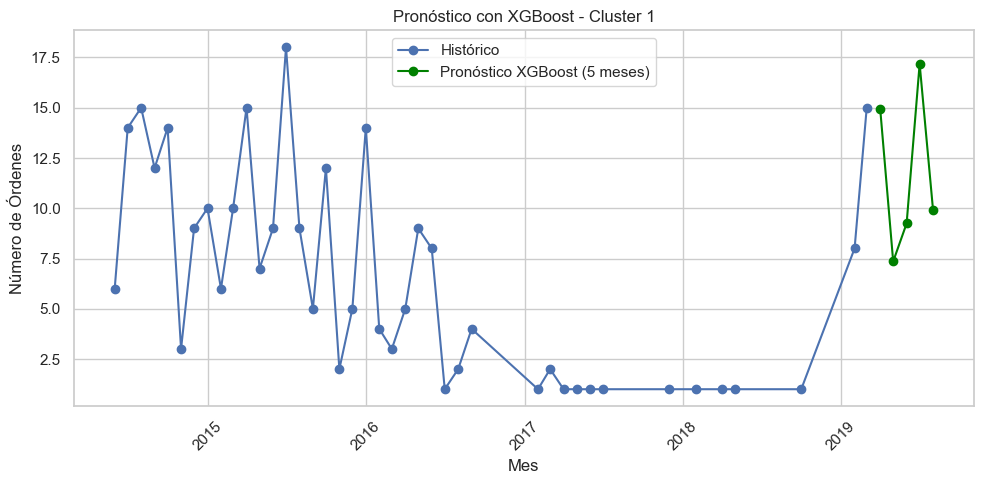

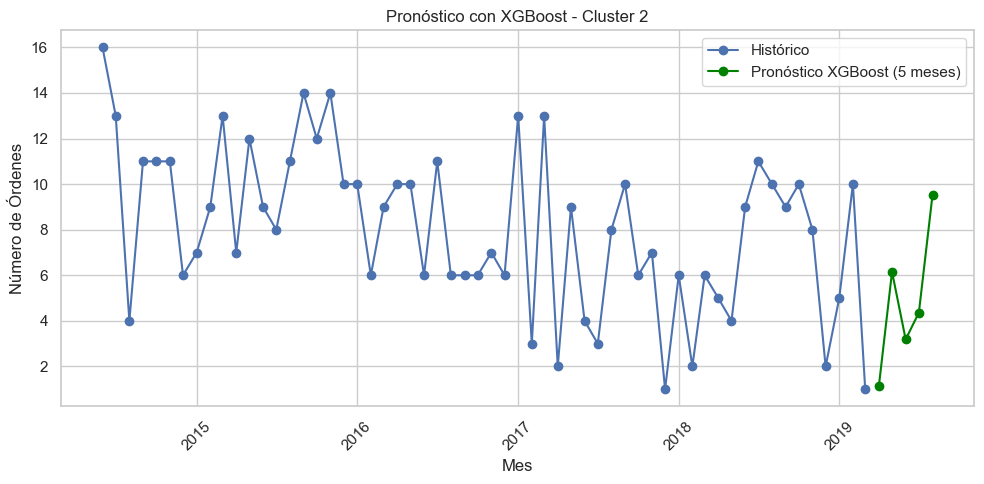

In [ ]:
#XGBoost

ventas_por_cluster['Aniomes'] = pd.to_datetime(ventas_por_cluster['Aniomes'])

# loop p cada cluster
for c in ventas_por_cluster['Cluster'].unique():
    subset = ventas_por_cluster[ventas_por_cluster['Cluster'] == c].copy()
    subset = subset.sort_values('Aniomes')
    subset = subset.set_index('Aniomes')

    #  variables rezagadas (lags de 1 a 4 meses)
    for lag in range(1, 5):
        subset[f'lag_{lag}'] = subset['Order Id'].shift(lag)

    subset['mes'] = subset.index.month
    subset['año'] = subset.index.year

    # Eliminacion NaN causadas por los lags
    subset = subset.dropna()

    # Variables predictoras y variable objetivo
    X = subset[['lag_1', 'lag_2', 'lag_3', 'mes', 'año']]
    y = subset['Order Id']

    # modelo
    model = XGBRegressor(n_estimators=100, learning_rate=0.1)
    model.fit(X, y)

    # Inicialización
    last_known = subset.iloc[-1].copy()
    predicciones = []
    fechas_futuras = []

    for i in range(1, 6):  # Predecir los próximos 5 meses
        nueva_fecha = pd.date_range(subset.index[-1], periods=i+1, freq='MS')[-1]
        fechas_futuras.append(nueva_fecha)

        mes = nueva_fecha.month
        año = nueva_fecha.year

        X_new = np.array([[last_known['lag_1'], last_known['lag_2'], last_known['lag_3'], mes, año]])
        pred = model.predict(X_new)[0]
        predicciones.append(pred)

        last_known['lag_3'] = last_known['lag_2']
        last_known['lag_2'] = last_known['lag_1']
        last_known['lag_1'] = pred

    forecast_df = pd.DataFrame({
        'fecha': fechas_futuras,
        'pred': predicciones
    }).set_index('fecha')

    # Gráfica
    plt.figure(figsize=(10, 5))
    plt.plot(subset.index, y, label='Histórico', marker='o')
    plt.plot(forecast_df.index, forecast_df['pred'], label='Pronóstico XGBoost (5 meses)', marker='o', color='green')
    plt.title(f'Pronóstico con XGBoost - Cluster {c}')
    plt.xlabel('Mes')
    plt.ylabel('Número de Órdenes')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Cluster 0 - MAE: 3.28, RMSE: 4.13, R²: -0.24


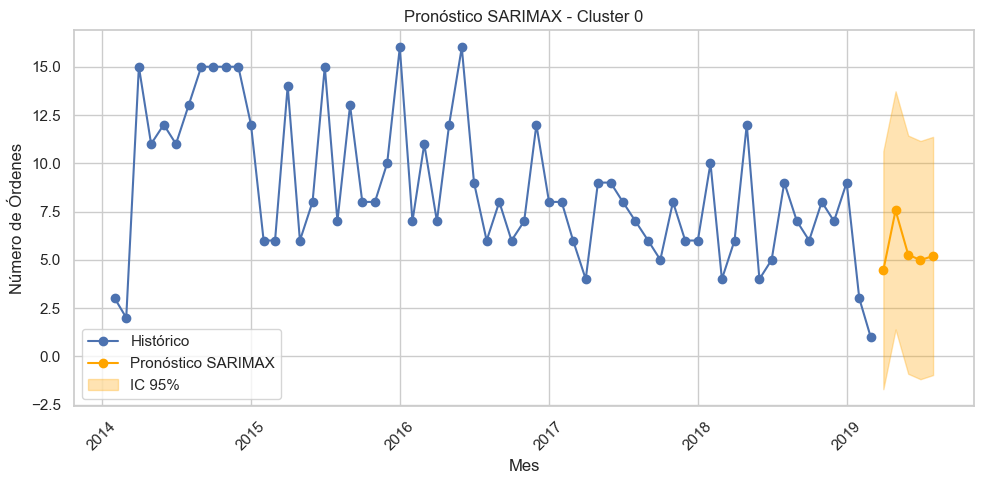

Cluster 1 - MAE: 5.13, RMSE: 6.45, R²: -0.38


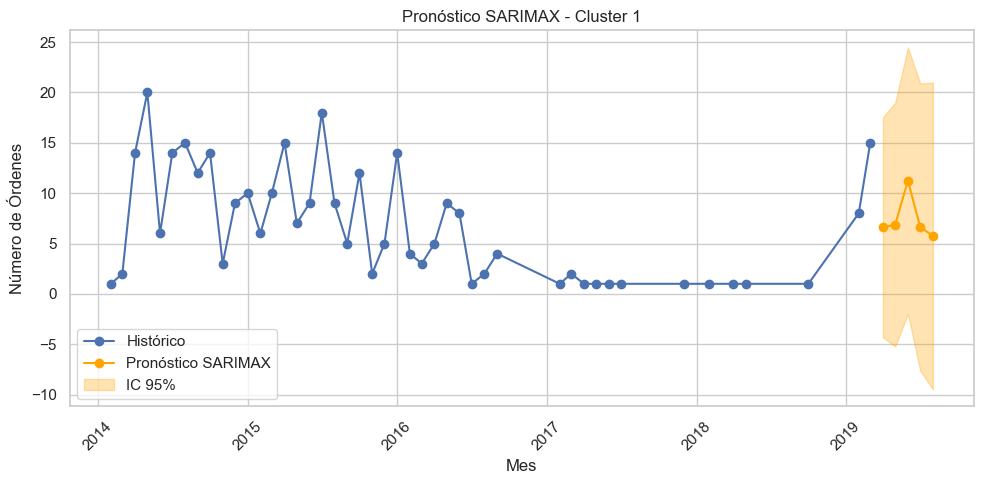

Cluster 2 - MAE: 4.31, RMSE: 6.38, R²: -0.59


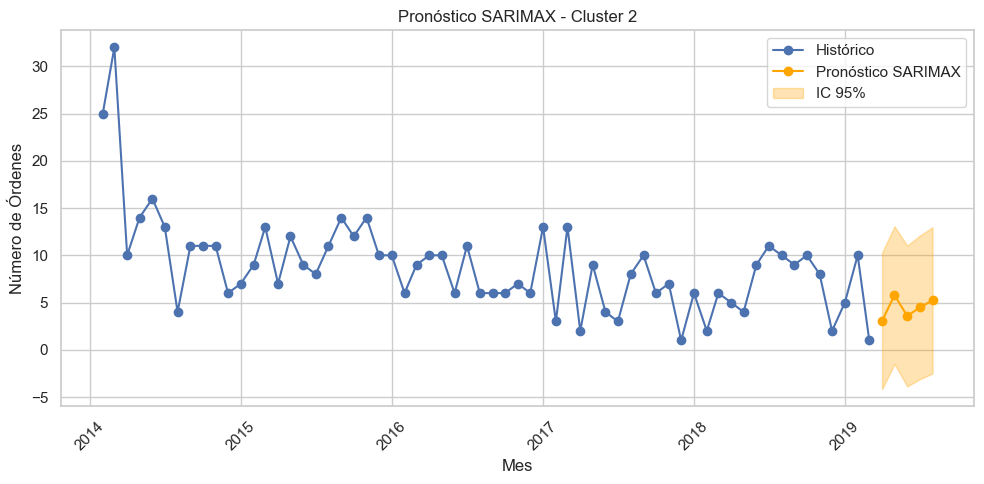

In [ ]:
# SARIMAX
ventas_por_cluster['Aniomes'] = pd.to_datetime(ventas_por_cluster['Aniomes'])

# Loop  p cada cluster
for c in ventas_por_cluster['Cluster'].unique():
    subset = ventas_por_cluster[ventas_por_cluster['Cluster'] == c].copy()
    subset = subset.sort_values('Aniomes')
    subset = subset.set_index('Aniomes')

    ts = subset['Order Id']

    try:
        model = SARIMAX(ts, 
                        order=(1,1,1),           
                        seasonal_order=(1,1,1,12),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        results = model.fit(disp=False)

        # Pronóstico
        n_steps = 5
        pred = results.get_forecast(steps=n_steps)
        pred_mean = pred.predicted_mean
        pred_ci = pred.conf_int()

        future_dates = pd.date_range(start=ts.index[-1] + pd.offsets.MonthBegin(1), periods=n_steps, freq='MS')

        forecast_df = pd.DataFrame({
            'forecast': pred_mean.values,
            'lower': pred_ci.iloc[:, 0].values,
            'upper': pred_ci.iloc[:, 1].values
        }, index=future_dates)

        # Métricas de evaluación
        y_pred_train = results.fittedvalues.dropna()
        y_true_train = ts.loc[y_pred_train.index]
        mae = mean_absolute_error(y_true_train, y_pred_train)
        rmse = np.sqrt(mean_squared_error(y_true_train, y_pred_train))
        r2 = r2_score(y_true_train, y_pred_train)

        print(f"Cluster {c} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

        # Graficar
        plt.figure(figsize=(10, 5))
        plt.plot(ts.index, ts.values, label='Histórico', marker='o')
        plt.plot(forecast_df.index, forecast_df['forecast'], label='Pronóstico SARIMAX', marker='o', color='orange')
        plt.fill_between(forecast_df.index, forecast_df['lower'], forecast_df['upper'], color='orange', alpha=0.3, label='IC 95%')
        plt.title(f'Pronóstico SARIMAX - Cluster {c}')
        plt.xlabel('Mes')
        plt.ylabel('Número de Órdenes')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Cluster {c} - Error al ajustar SARIMAX: {e}")


en el caso del cluster 1 no hay venta para algunos meses

# Breve análisis de la Demanda

En este caso el análisis de la demanda es muy sencillo, Lo mejor sería poder contar con más variables que aportaran infromacion a la composicion de la demanda de estos productos, ya que una simple relacion entre cantidad y precio parece ser insuficiente, haría falta ver los tipos de productos, productos relativos como sustitutos, complementos, variables relativas al ingreso, tendencias en las preferencias de los consumidores etc.

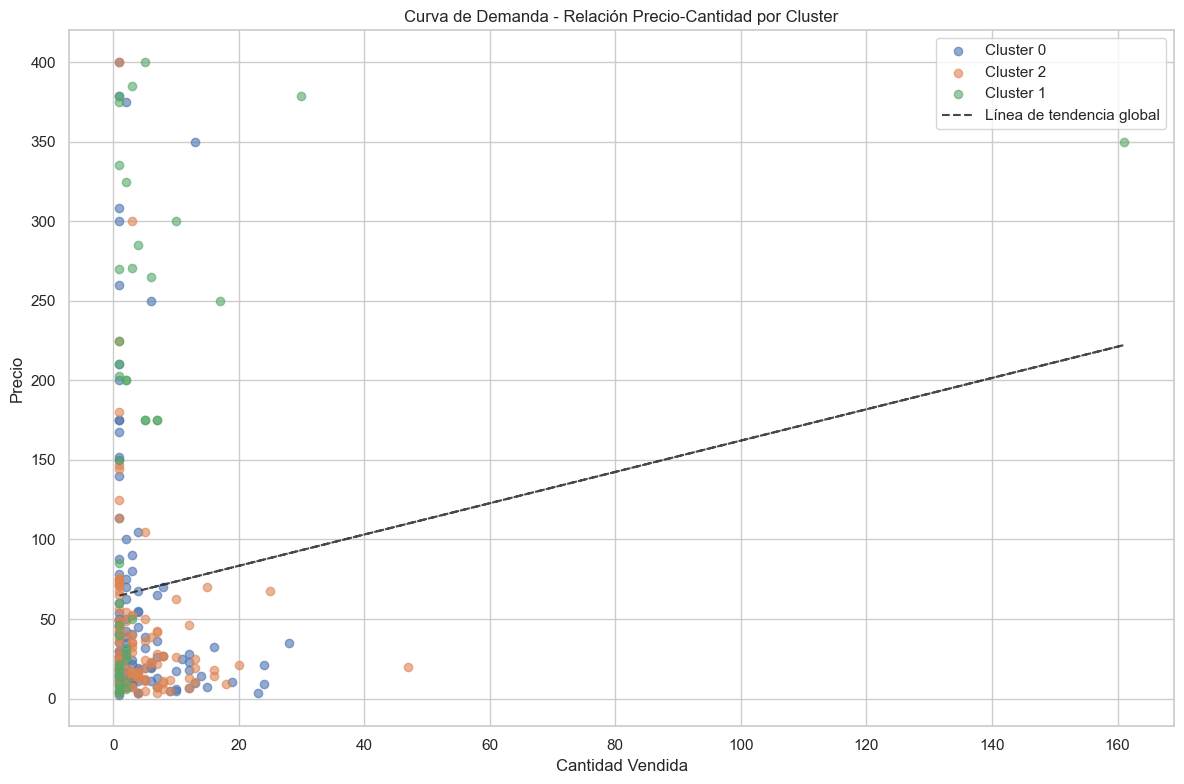

In [ ]:
# Cantidad vendida por producto y precio -  el Cluster
demanda = df_filtrado.groupby(['Product Id', 'Price', 'Cluster']).size().reset_index(name='Cantidad')

demanda['Cluster'] = demanda['Cluster'].astype(str)

# Grafica
plt.figure(figsize=(12, 8))

# puntos por cluster
for cluster in demanda['Cluster'].unique():
    subset = demanda[demanda['Cluster'] == cluster]
    plt.scatter(subset['Cantidad'], subset['Price'], alpha=0.6, label=f'Cluster {cluster}')

# Línea de tendencia
z = np.polyfit(demanda['Cantidad'], demanda['Price'], 1)
p = np.poly1d(z)
plt.plot(demanda['Cantidad'], p(demanda['Cantidad']), "k--", alpha=0.8, label='Línea de tendencia global')

plt.title('Curva de Demanda - Relación Precio-Cantidad por Cluster')
plt.xlabel('Cantidad Vendida')
plt.ylabel('Precio')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# linea de regresion de la demanda:
en la figura anterior se aprecia una linea de regresión para la demanda de productos con pendiente positiva, esto puede parecer contradictorio y el principal motivo es el outlier cerca de (160, 350) sin embargo tambien se puede ver que los datos estan "aglomerados" por lo que sería bueno mejorar el analisis usando un modelo LOG - LOG
esto tambien nos ayudará a calcular facimente la elasticidad precio de la demada.

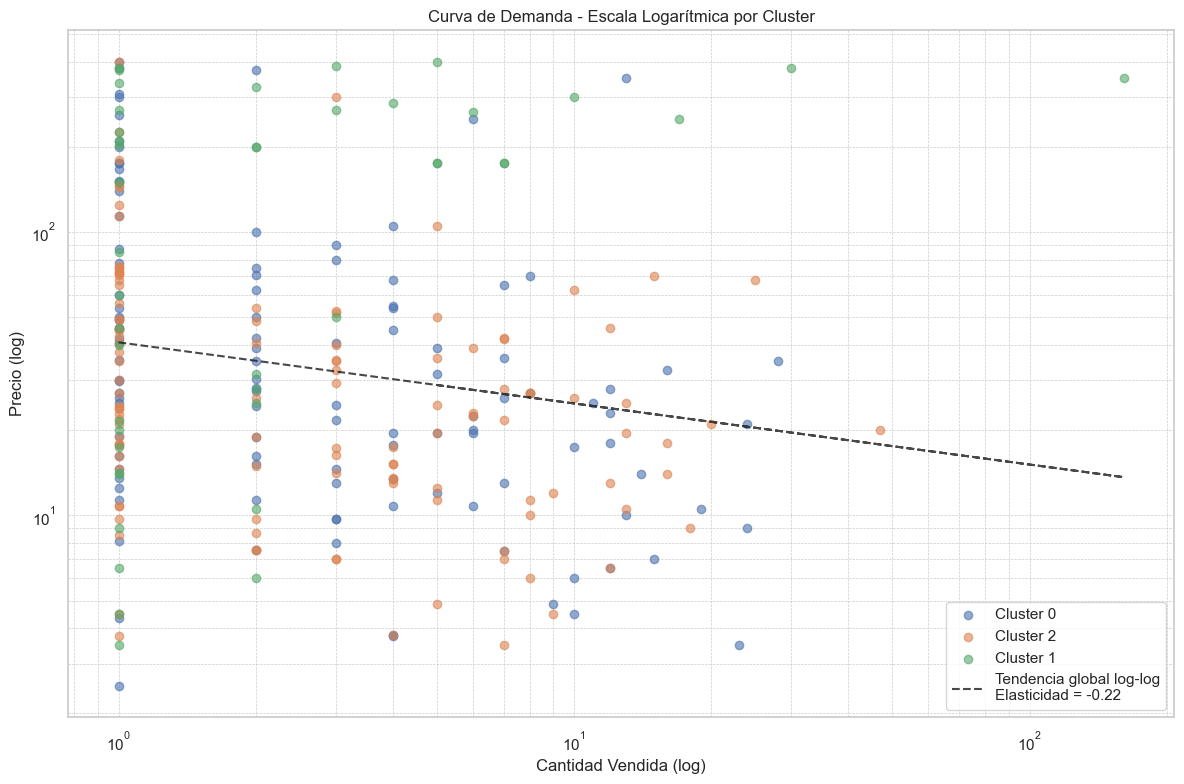

Elasticidad precio de la demanda (global): -0.22


In [ ]:
# Modelo Log - Log
demanda['Cluster'] = demanda['Cluster'].astype(str)

plt.figure(figsize=(12, 8))

# Grafica
for cluster in demanda['Cluster'].unique():
    subset = demanda[demanda['Cluster'] == cluster]
    plt.scatter(subset['Cantidad'], subset['Price'], alpha=0.6, label=f'Cluster {cluster}')

# Línea de tendencia  log-log
z = np.polyfit(np.log(demanda['Cantidad']), np.log(demanda['Price']), 1)
p = np.poly1d(z)

# Elasticidad precio de la demanda
elasticidad = z[0]

cantidad_log = np.log(demanda['Cantidad'])
plt.plot(demanda['Cantidad'], np.exp(p(cantidad_log)), "k--", alpha=0.8,
         label=f'Tendencia global log-log\nElasticidad = {elasticidad:.2f}')

# Escalas logarítmicas
plt.xscale('log')
plt.yscale('log')

# Etiquetas
plt.title('Curva de Demanda - Escala Logarítmica por Cluster')
plt.xlabel('Cantidad Vendida (log)')
plt.ylabel('Precio (log)')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Mostrar valor numérico
print(f"Elasticidad precio de la demanda (global): {elasticidad:.2f}")


Un aumento del 1% en el precio se asocia con una caída del 0.22% en la cantidad demandada, en promedio.
Sería bueno realizar este análisis por producto, pero no todos los productos tienen suficientes datos, ademas de que es importante un analisis detallado de demanda ocnsiderando otros elementos que no estan disponibles en el dataset.